In [ ]:
import dgl
import torch
import torch.nn as nn
import numpy as np
import networkx as nx

In [ ]:
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [ ]:
from torch.utils.data import DataLoader

number_examples = 2000
min_number_nodes = 32
max_number_nodes = 64

num_train_examples = int(number_examples * 0.8)
num_test_examples = number_examples - num_train_examples
minibatch_size = 16

train_set = dgl.data.MiniGCDataset(num_train_examples, min_number_nodes, max_number_nodes, seed=0)
test_set = dgl.data.MiniGCDataset(num_test_examples, min_number_nodes * 2, max_number_nodes * 2, seed=0)

train_dataloader = DataLoader(
    train_set, batch_size=minibatch_size, drop_last=False, shuffle=True, collate_fn=collate)
test_dataloader = DataLoader(
    test_set, batch_size=minibatch_size, drop_last=False, shuffle=True, collate_fn=collate)

In [ ]:
graph, label = train_set[0]
print(graph, label)

Graph(num_nodes=44, num_edges=132,
      ndata_schemes={}
      edata_schemes={}) tensor(0)


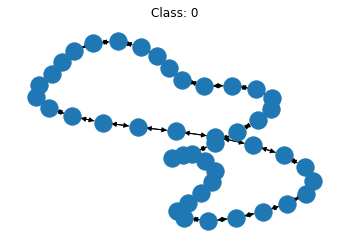

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, graph):
        h = graph.in_degrees().view(-1, 1).float() # Use node degree as the initial node feature
        h = self.conv1(graph, h)
        h = nn.functional.relu(h)
        h = self.conv2(graph, h)
        h = nn.functional.relu(h)
        graph.ndata['h'] = h
        
        global_h = dgl.mean_nodes(graph, 'h')
        return self.classifier(global_h)

In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, int(hidden_dim / 2))
        self.conv4 = GraphConv(int(hidden_dim / 2), int(hidden_dim / 4))
        self.classifier = nn.Linear(int(hidden_dim / 4), num_classes)

    def forward(self, graph):
        h = graph.in_degrees().view(-1, 1).float() # Use node degree as the initial node feature
        h = self.conv1(graph, h)
        h = nn.functional.relu(h)
        h = self.conv2(graph, h)
        h = nn.functional.relu(h)
        h = self.conv3(graph, h)
        h = nn.functional.relu(h)
        h = self.conv4(graph, h)
        h = nn.functional.relu(h)
        graph.ndata['h'] = h
        
        global_h = dgl.mean_nodes(graph, 'h')
        return self.classifier(global_h)

In [ ]:
def train(graphs, model, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs+1):
        for batched_graph, labels in train_dataloader:
            pred = model(batched_graph)
            loss = nn.functional.cross_entropy(pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        num_correct = 0
        num_tests = 0
        for batched_graph, labels in test_dataloader:
            pred = model(batched_graph)
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)

        if epoch % 5 == 0:
            print('In epoch {}, training loss: {:4f}, test accuracy: {}%'.format(
                epoch, loss, (num_correct / num_tests) * 100))

In [ ]:
model = model = GCN(1, 256, train_set.num_classes)
train(train_set, model, 100)

In epoch 0, training loss: 1.646132, test accuracy: 12.5%
In epoch 5, training loss: 0.505667, test accuracy: 66.5%
In epoch 10, training loss: 0.352100, test accuracy: 68.75%
In epoch 15, training loss: 0.265617, test accuracy: 69.0%
In epoch 20, training loss: 0.088652, test accuracy: 69.75%
In epoch 25, training loss: 0.271545, test accuracy: 73.75%
In epoch 30, training loss: 0.145678, test accuracy: 70.75%
In epoch 35, training loss: 0.076282, test accuracy: 73.75%
In epoch 40, training loss: 0.113028, test accuracy: 73.25%
In epoch 45, training loss: 0.158721, test accuracy: 73.0%
In epoch 50, training loss: 0.034646, test accuracy: 73.0%
In epoch 55, training loss: 0.012650, test accuracy: 77.5%
In epoch 60, training loss: 0.004224, test accuracy: 78.25%
In epoch 65, training loss: 0.021220, test accuracy: 76.5%
In epoch 70, training loss: 0.164128, test accuracy: 78.5%
In epoch 75, training loss: 0.001268, test accuracy: 78.25%
In epoch 80, training loss: 0.003670, test accurac